## AM115 Group Project - First Draft

## SEIRD Model
- states: Susceptible, Infected, Exposed, Dead, Recovered

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [67]:
def nc_func(t, sharpness, min_val=1, max_val=8):
    """For a given time t, calculate the contact rate nc.
    The contact rate decreases exponentially after a certain time
    due to lockdown measures. The function is bounded between
    min_val and max_val. The sharpness parameter controls how quickly
    the contact rate drops.
    """
    # Time after which lockdown starts
    lockdown_start = 5
    t0 = max(t - lockdown_start, 0)
    drop = (max_val - min_val) * np.exp(sharpness * t0)
    return min(max_val, min_val + drop)

$$
a(t) = pt \cdot nc(t)
$$
$$
nc(t) = (nc_{max} - 1) \cdot e^{t_{start} * s}
$$

In [116]:
# ts = np.linspace(0, 10, 100)
# sharpness = -2
# ncs = [nc_func(ti, sharpness) for ti in ts]
# plt.figure(figsize=(10, 5))
# plt.plot(ts, ncs, label="Contact Rate (nc)", color="purple")
# plt.xlabel("Time")
# plt.ylabel("Contact Rate (nc)")
# plt.title("Contact Rate Over Time with Lockdown")
# plt.grid()
# plt.legend()
# plt.show()

In [117]:
def lockdown_intensity(t, sharpness, nc_min=1, nc_max=8):
    """Normalizes the contact rate nc to a value between 0 and 1.
    This is done via min-max scaling.
    """
    nc = nc_func(t, sharpness, nc_min, nc_max)
    return (nc_max - nc) / (nc_max - nc_min)

In [118]:
def economic_cost(t, alpha, sharpness):
    # alpha is the weight for economic cost
    # alpha = 1 means human life is 10m
    # alpha = 0.5 means human life is 5m
    return alpha * lockdown_intensity(t, sharpness)

In [120]:
def simulate_seird(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N):
    def rhs(t, X):
        nc = nc_func(t, sharpness)
        a = pt * nc
        s, e, i, r, d = X
        ds = -a * s * i / N - c * s + gamma * r
        de = a * s * i / N - nu * e
        di = nu * e - b * i - eta * i
        dr = b * i + c * s - gamma * r
        dd = eta * i
        return [ds, de, di, dr, dd]

    sol = solve_ivp(rhs, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], 400))
    return sol

In [121]:
def total_cost(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N):
    sol = simulate_seird(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N)
    t = sol.t
    deaths = sol.y[4]
    death_cost = deaths[-1]
    econ_cost = np.trapz([economic_cost(ti, alpha, sharpness) for ti in t], t)
    return death_cost + econ_cost

In [ ]:
from scipy.optimize import minimize_scalar

# Define parameters
t_span = (0, 60)
N = 1000
y0 = [999, 1, 0, 0, 0]
pt = 0.1
b = 0.1
c = 0.001
eta = 0.01
gamma = 0.001
nu = 0.2
alpha = 1  # weight of economic cost

res = minimize_scalar(
    total_cost,
    bounds=(-2.0, -0.01),
    method="bounded",
    args=(alpha, t_span, y0, pt, b, c, eta, gamma, nu, N),
)


print(f"Optimal sharpness: {res.x:.4f}")
print(f"Minimum total cost: {res.fun:.2f}")

Optimal sharpness: -0.1376
Minimum total cost: 52.10


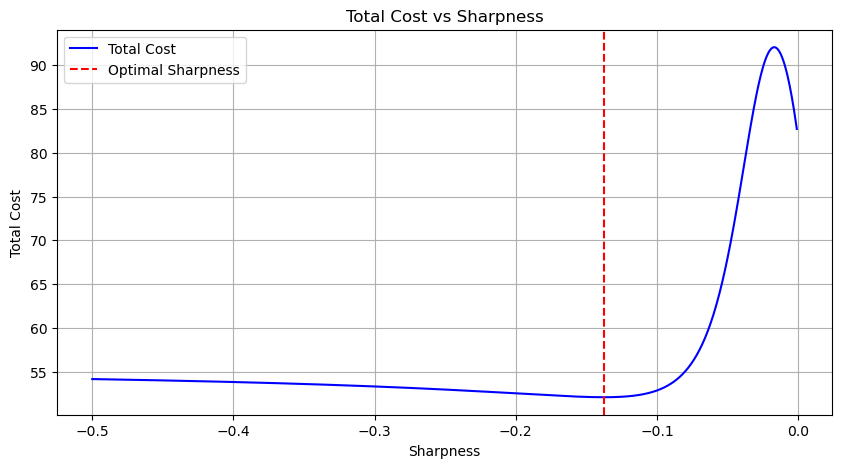

In [125]:
# plot total cost as a function of sharpness
sharpness_values = np.linspace(-0.5, -0.001, 1000)
total_costs = [
    total_cost(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N)
    for sharpness in sharpness_values
]
plt.figure(figsize=(10, 5))
plt.plot(sharpness_values, total_costs, label="Total Cost", color="blue")
plt.axvline(res.x, color="red", linestyle="--", label="Optimal Sharpness")
plt.xlabel("Sharpness")
plt.ylabel("Total Cost")
plt.title("Total Cost vs Sharpness")
plt.legend()
plt.grid()
plt.show()

- pt: probability of transmission per contact
- nc: number of contacts
- b: recovery rate
- c: preemptive protection rate (e.g. vaccination)
- d_rate: death rate (from I)
- e_rate: immunity waning rate (R → S)
- f: rate E → I (incubation rate)
- N: total population

The system of ODEs:
$$
\frac{dS}{dt} = - \frac{a(t)}{N} I S - c S + \gamma R
$$

$$
\frac{dE}{dt} = \frac{a(t)}{N} I S - \nu E
$$

$$
\frac{dI}{dt} = \nu E - b I - \eta I
$$

$$
\frac{dR}{dt} = b I + c S - \gamma R
$$

$$
\frac{dD}{dt} = \eta I
$$

Parameters:
$$
a(t) = pt \cdot nc(t)
$$
$$
nc(t) = 1 + 5 e^{-0.5  \max(t - 5, 0)}
$$
- $nc$ is a gradual lockdown

In [153]:
def seird(t, X, pt, nc, b, c, eta, gamma, nu, N, lockdown=False, sharpness=None):
    if lockdown:
        nc_val = nc_func(t, sharpness)
    else:
        nc_val = nc

    a = pt * nc_val
    s, e, i, r, d = X
    ds = -a * s * i / N - c * s + gamma * r
    de = a * s * i / N - nu * e
    di = nu * e - b * i - eta * i
    dr = b * i + c * s - gamma * r
    dd = eta * i
    return [ds, de, di, dr, dd]

In [154]:
# Set parameters according to the problem specs
tspan = [0.0, 40]
t_eval = np.arange(0, 40, 0.1)
# R0 is 4 in this case
nc = 8
pt = 0.5
b = 1
# vaccination proportion
c = 0.05
N = 1000
eta = 0.05  # death rate from infected
gamma = 0.01  # immunity waning rate
nu = 0.95  # incubation rate


# S, E, I, R, D
X0 = [990, 9, 1, 0, 0]
sharpness = -0.1

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol = solve_ivp(
    lambda t, X: seird(
        t, X, pt, nc, b, c, eta, gamma, nu, N, lockdown=False, sharpness=sharpness
    ),
    tspan,
    X0,
    t_eval=t_eval,
    method="Radau",
)
# Unpack solution
T, X = sol.t, sol.y

# S, E, I, R, D
X0 = [990, 9, 1, 0, 0]

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol_lock = solve_ivp(
    lambda t, X: seird(
        t, X, pt, nc, b, c, eta, gamma, nu, N, lockdown=True, sharpness=sharpness
    ),
    tspan,
    X0,
    t_eval=t_eval,
    method="Radau",
)
# Unpack solution
T_lock, X_lock = sol_lock.t, sol_lock.y

In [155]:
from scipy.integrate import simpson

alpha = 1000
lockdown_cost = simpson([economic_cost(t, alpha, sharpness) for t in T_lock], T_lock)

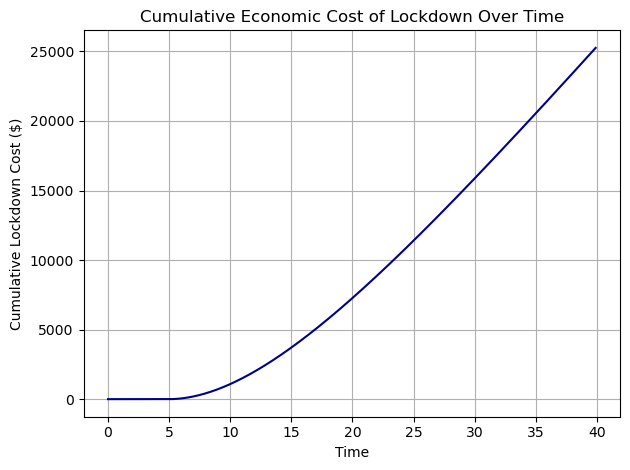

In [156]:
cost_over_time = [economic_cost(t, alpha, sharpness) for t in T_lock]
dt = T_lock[1] - T_lock[0]

# Cumulative cost: integrate cost over time using simple trapezoidal rule
cumulative_cost = np.cumsum(cost_over_time) * dt

plt.plot(T_lock, cumulative_cost, color="darkblue")
plt.xlabel("Time")
plt.ylabel("Cumulative Lockdown Cost ($)")
plt.title("Cumulative Economic Cost of Lockdown Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [157]:
from scipy.integrate import simpson

alpha = 1000
lockdown_cost = simpson([economic_cost(t, alpha, sharpness) for t in T], T)

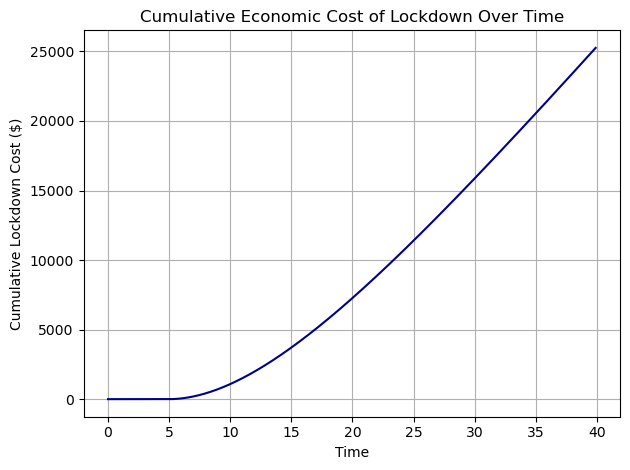

In [158]:
cost_over_time = [economic_cost(t, alpha, sharpness) for t in T]
dt = T[1] - T[0]

# Cumulative cost: integrate cost over time using simple trapezoidal rule
cumulative_cost = np.cumsum(cost_over_time) * dt

plt.plot(T, cumulative_cost, color="darkblue")
plt.xlabel("Time")
plt.ylabel("Cumulative Lockdown Cost ($)")
plt.title("Cumulative Economic Cost of Lockdown Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

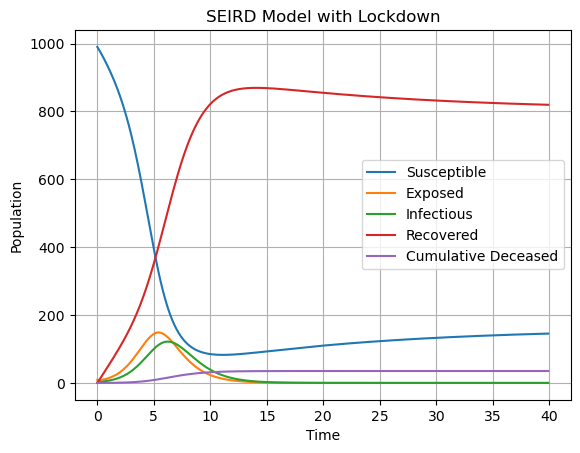

In [159]:
import matplotlib.pyplot as plt

labels = ["Susceptible", "Exposed", "Infectious", "Recovered", "Cumulative Deceased"]
for i in range(5):
    plt.plot(T_lock, X_lock[i], label=labels[i])
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SEIRD Model with Lockdown")
plt.legend()
plt.grid(True)
plt.show()

In [162]:
# Parameters
tspan = [0.0, 40]
t_eval = np.arange(0, 40, 0.1)

nc = 8
pt = 0.5
b = 1
c = 0.05
N = 1000
eta = 0.05
gamma = 0.01
nu = 0.95

X0 = [990, 0, 1, 0, 0]
sharpness = -0.1

# Solve without lockdown (fixed contact rate)
sol = solve_ivp(
    lambda t, X: seird(
        t, X, pt, nc, b, c, eta, gamma, nu, N, lockdown=False, sharpness=sharpness
    ),
    tspan,
    X0,
    t_eval=t_eval,
    method="Radau",
)
T_nolockdown, X_nolockdown = sol.t, sol.y

# Solve with lockdown (time-varying contact rate)
sol_lock = solve_ivp(
    lambda t, X: seird(
        t, X, pt, nc, b, c, eta, gamma, nu, N, lockdown=True, sharpness=sharpness
    ),
    tspan,
    X0,
    t_eval=t_eval,
    method="Radau",
)
T_lock, X_lock = sol_lock.t, sol_lock.y

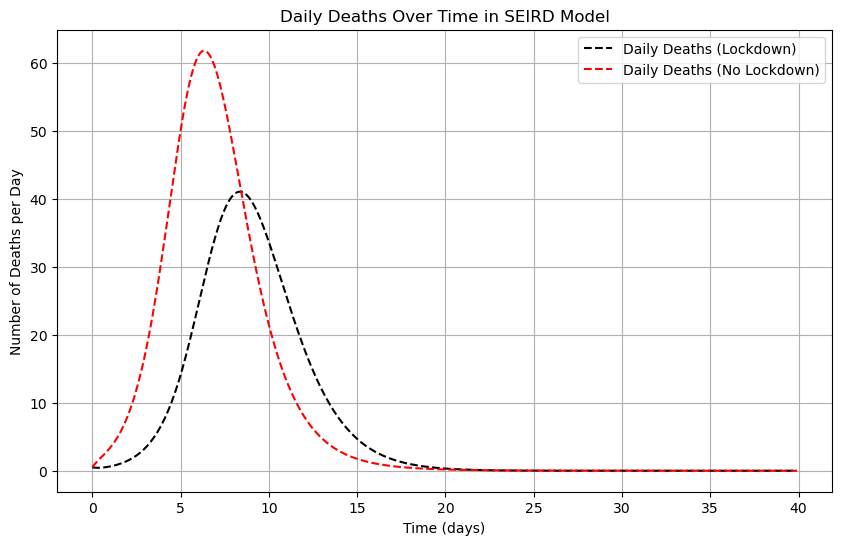

In [163]:
dt = t_eval[1] - t_eval[0]  # 0.1 days

daily_deaths = eta * X_lock[2] / dt
daily_deaths_no_lockdown = eta * X[2] / dt

plt.figure(figsize=(10, 6))
plt.plot(
    T_lock, daily_deaths, label="Daily Deaths (Lockdown)", color="black", linestyle="--"
)
plt.plot(
    T,
    daily_deaths_no_lockdown,
    label="Daily Deaths (No Lockdown)",
    color="red",
    linestyle="--",
)
plt.xlabel("Time (days)")
plt.ylabel("Number of Deaths per Day")
plt.title("Daily Deaths Over Time in SEIRD Model")
plt.legend()
plt.grid(True)
plt.show()

Sensitivity Analysis Ideas
- Sharp lockdown

Sources
1. https://como-dtc-collaboration.github.io/como-models/articles/SEIRD.html
2. https://www.nature.com/articles/s41598-021-97260-0

## Parameters Research
- sensitivity of optimal sharpness for different alpha
- sensitivity of optimal sharpness for different pt

In [511]:
# Customize for matplotlib
# If interested in the matplotlib object hierarchy, check: https://realpython.com/python-matplotlib-guide/
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["mathtext.default"] = "regular"
# Change font size: http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["figure.titlesize"] = 20

In [761]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [762]:
def nc_func(t, sharpness, min_val=1, max_val=6):
    """For a given time t, calculate the contact rate nc.
    The contact rate decreases exponentially after a certain time
    due to lockdown measures. The function is bounded between
    min_val and max_val. The sharpness parameter controls how quickly
    the contact rate drops.
    """
    # Time after which lockdown starts
    lockdown_start = 5
    t0 = max(t - lockdown_start, 0)
    drop = (max_val - min_val) * np.exp(sharpness * t0)
    return min(max_val, min_val + drop)

$$
a(t) = pt \cdot nc(t)
$$
$$
nc(t) = (nc_{max} - 1) \cdot e^{t_{start} * s}
$$

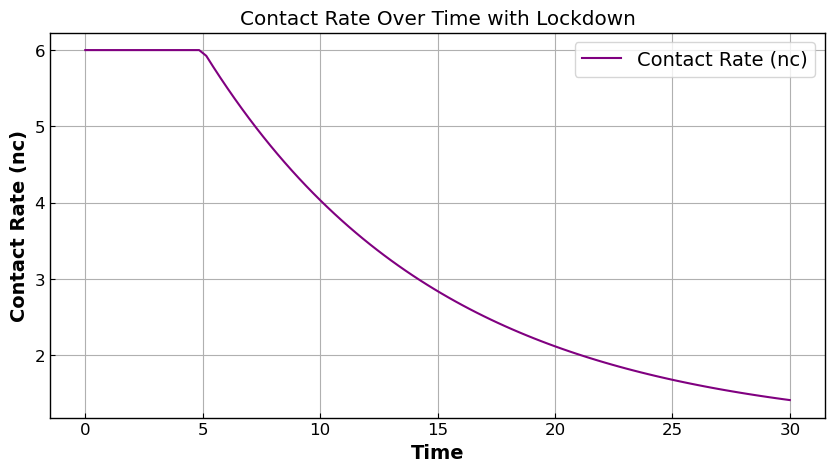

In [763]:
ts = np.linspace(0, 30, 100)
sharpness = -0.1
ncs = [nc_func(ti, sharpness) for ti in ts]
plt.figure(figsize=(10, 5))
plt.plot(ts, ncs, label="Contact Rate (nc)", color="purple")
plt.xlabel("Time")
plt.ylabel("Contact Rate (nc)")
plt.title("Contact Rate Over Time with Lockdown")
plt.grid()
plt.legend()
plt.show()

In [764]:
def lockdown_intensity(t, sharpness, nc_min=1, nc_max=6):
    """Normalizes the contact rate nc to a value between 0 and 1.
    This is done via min-max scaling.
    """
    nc = nc_func(t, sharpness, nc_min, nc_max)
    return (nc_max - nc) / (nc_max - nc_min)

In [765]:
def economic_cost(t, alpha, sharpness):
    # alpha is the weight for economic cost
    # alpha = 1 means human life is 10m
    # alpha = 0.5 means human life is 5m
    return alpha * lockdown_intensity(t, sharpness)

In [766]:
def simulate_seird(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N):
    def rhs(t, X):
        nc = nc_func(t, sharpness)
        a = pt * nc
        s, e, i, r, d = X
        ds = -a * s * i / N - c * s + gamma * r
        de = a * s * i / N - nu * e
        di = nu * e - b * i - eta * i
        dr = b * i + c * s - gamma * r
        dd = eta * i
        return [ds, de, di, dr, dd]

    sol = solve_ivp(rhs, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], 400))
    return sol

In [767]:
def total_cost(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N):
    sol = simulate_seird(sharpness, alpha, t_span, y0, pt, b, c, eta, gamma, nu, N)
    t = sol.t
    deaths = sol.y[4]
    death_cost = deaths[-1]
    econ_cost = np.trapz([economic_cost(ti, alpha, sharpness) for ti in t], t)
    return death_cost + econ_cost

In [768]:
from scipy.optimize import minimize_scalar

# Define parameters
t_span = (0, 90)
t_eval = np.arange(0, 90, 0.1)
N = 1000
# SEIRD
X0 = [990, 10, 0, 0, 0]
# nc ranges from 6 to 1
# vary this to match the R0
pt = 0.1
# research found ranges from 0.03 to 0.06
b = 0.05
# The vacinnation rate from 2020-2021 was around 0.013
c = 0.013
# the death rate from infected was 0.008 but we round
eta = 0.008
gamma = 0.008
nu = 0.22
alpha = 1  # weight of economic cost

In [769]:
a = 6 * pt
r0 = a / b
print(r0)

12.000000000000002


In [770]:
def seird(t, X, pt, nc, b, c, eta, gamma, nu, N, lockdown=False, sharpness=None):
    if lockdown:
        nc_val = nc_func(t, sharpness)
    else:
        nc_val = nc

    a = pt * nc_val
    s, e, i, r, d = X
    ds = -a * s * i / N - c * s + gamma * r
    de = a * s * i / N - nu * e
    di = nu * e - b * i - eta * i
    dr = b * i + c * s - gamma * r
    dd = eta * i
    return [ds, de, di, dr, dd]

In [788]:
# Parameters
tspan = (0, 100)
t_eval = np.arange(0, 100, 0.1)
N = 1000
# nc ranges from 6 to 1
# vary this to match the R0
pt = 0.1
# research found ranges from 0.03 to 0.06
b = 0.05
# The vacinnation rate from 2020-2021 was around 0.013
c = 0.013
# the death rate from infected was 0.008 but we round
eta = 0.03
gamma = 0.008
nu = 0.22
alpha = 1  # weight of economic cost


X0 = [999, 1, 0, 0, 0]
sharpness = -0.1

# Solve without lockdown (fixed contact rate)
sol = solve_ivp(
    lambda t, X: seird(
        t, X, pt, nc, b, c, eta, gamma, nu, N, lockdown=False, sharpness=sharpness
    ),
    tspan,
    X0,
    t_eval=t_eval,
    method="Radau",
)
T_nolockdown, X_nolockdown = sol.t, sol.y

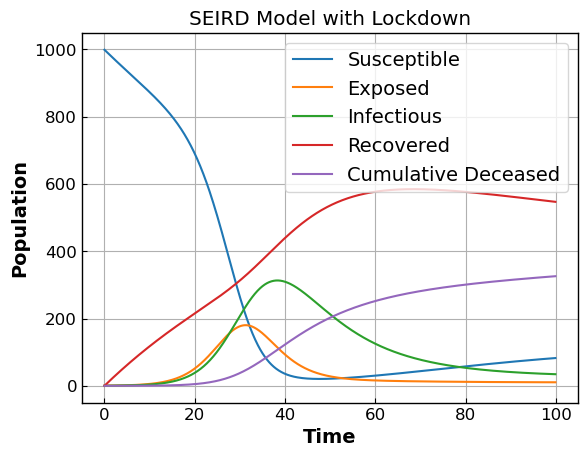

In [789]:
import matplotlib.pyplot as plt

labels = ["Susceptible", "Exposed", "Infectious", "Recovered", "Cumulative Deceased"]
for i in range(5):
    plt.plot(T_nolockdown, X_nolockdown[i], label=labels[i])
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SEIRD Model with Lockdown")
plt.legend()
plt.grid(True)
plt.show()

In [780]:
res = minimize_scalar(
    total_cost,
    bounds=(-0.5, -0.01),
    method="bounded",
    args=(alpha, t_span, X0, pt, b, c, eta, gamma, nu, N),
)


print(f"Optimal sharpness: {res.x:.4f}")
print(f"Minimum total cost: {res.fun:.2f}")

Optimal sharpness: -0.1676
Minimum total cost: 84.46


- $\alpha = 0.5$ implies \$5M of economic impact is valued equivalently to 1 life lost (since $\alpha$ = 0.5 means the model treats 0.5 units of economic cost = 1 death).
- we use 1 unit of economic cost = 1 death as a baseline for our model.
- Let a life be worth \$10M, then $\alpha = 0.1$ implies \$1M of economic impact is valued equivalently to 1 life lost (since $\alpha$ = 0.1 means the model treats 0.1 units of economic cost = 1 death).

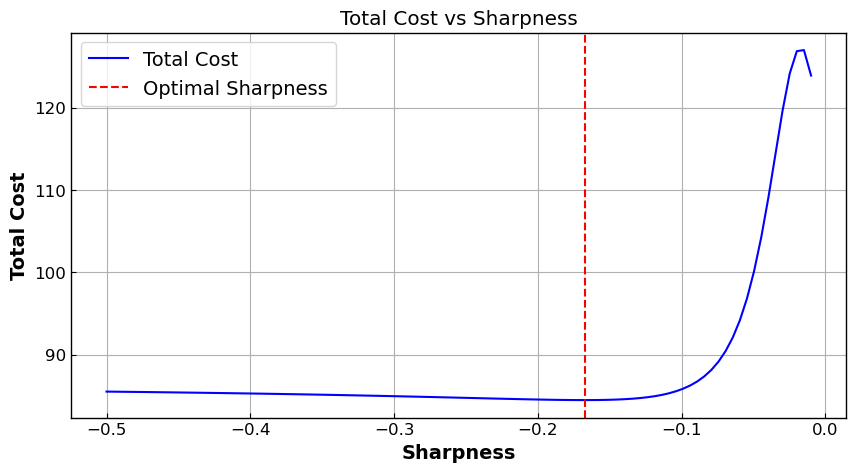

In [781]:
# plot total cost as a function of sharpness
sharpness_values = np.linspace(-0.5, -0.01, 100)
total_costs = [
    total_cost(sharpness, alpha, t_span, X0, pt, b, c, eta, gamma, nu, N)
    for sharpness in sharpness_values
]
plt.figure(figsize=(10, 5))
plt.plot(sharpness_values, total_costs, label="Total Cost", color="blue")
plt.axvline(res.x, color="red", linestyle="--", label="Optimal Sharpness")
plt.xlabel("Sharpness")
plt.ylabel("Total Cost")
plt.title("Total Cost vs Sharpness")
plt.legend()
plt.grid()
plt.show()

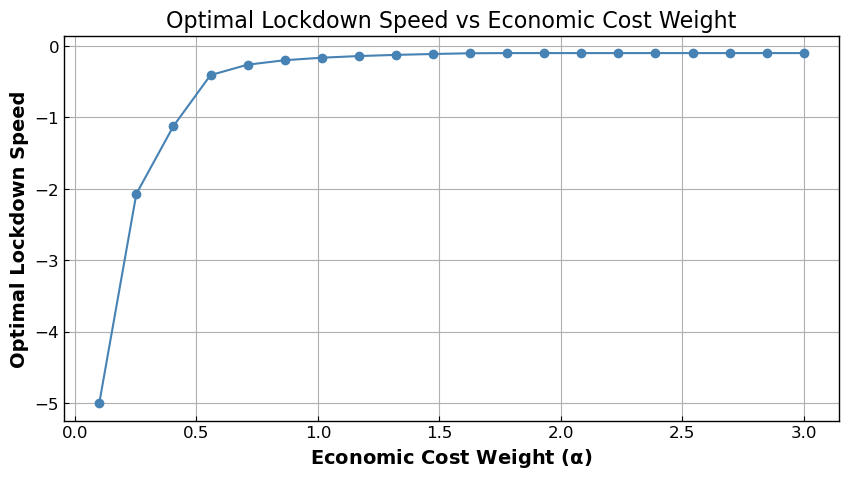

In [782]:
# plot optimal lockdown steepness vs alpha

num_candidates = 20
optimal_sharpness = np.zeros(num_candidates)
candidate_alphas = np.linspace(0.1, 3.0, num_candidates)  # Economic cost weights
for i, alpha in enumerate(candidate_alphas):
    res = minimize_scalar(
        total_cost,
        bounds=(-5.0, -0.1),
        method="bounded",
        args=(alpha, t_span, X0, pt, b, c, eta, gamma, nu, N),
    )
    optimal_sharpness[i] = res.x

plt.figure(figsize=(10, 5))
plt.plot(candidate_alphas, optimal_sharpness, marker="o", color="steelblue")
plt.xlabel("Economic Cost Weight ($\\alpha$)")
plt.ylabel("Optimal Lockdown Speed")
plt.title("Optimal Lockdown Speed vs Economic Cost Weight", fontsize=16)
plt.grid()
plt.show()

- an alpha = 1 is valuing 1 human life at \$10M
- an alpha = 2 is valuing 1 human life at \$20M
- as the value of alpha increase the steepness of the lockdown becomes more shallow because the economic cost is more expensive

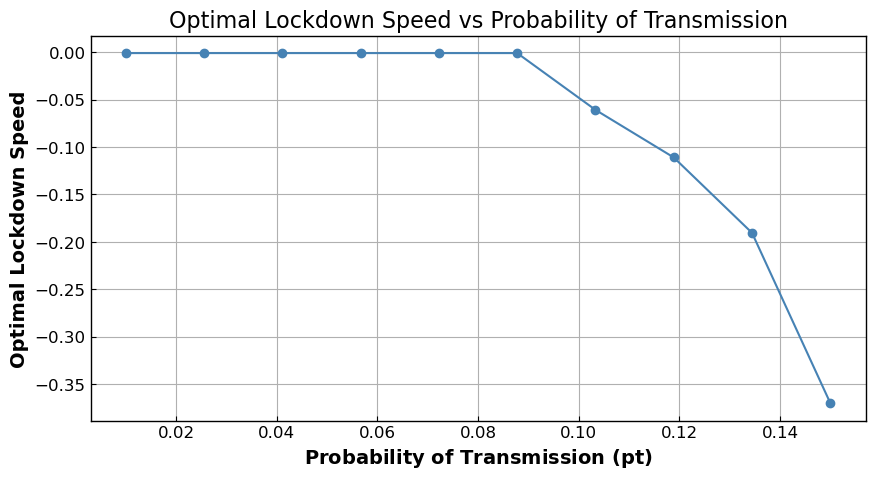

In [783]:
# sensitivity of optimal sharpness for different pt

pt_values = np.linspace(0.01, 0.15, 10)
optimal_sharpness_pt = np.zeros(len(pt_values))
for i, pt in enumerate(pt_values):
    res = minimize_scalar(
        total_cost,
        bounds=(-5.0, -0.001),
        method="bounded",
        args=(alpha, t_span, X0, pt, b, c, eta, gamma, nu, N),
    )
    optimal_sharpness_pt[i] = res.x

plt.figure(figsize=(10, 5))
plt.plot(pt_values, optimal_sharpness_pt, marker="o", color="steelblue")
plt.xlabel("Probability of Transmission ($pt$)")
plt.ylabel("Optimal Lockdown Speed")
plt.title("Optimal Lockdown Speed vs Probability of Transmission", fontsize=16)
plt.grid()
plt.show()

- probability of transmission varies depending on environment 0.01 to 0.2

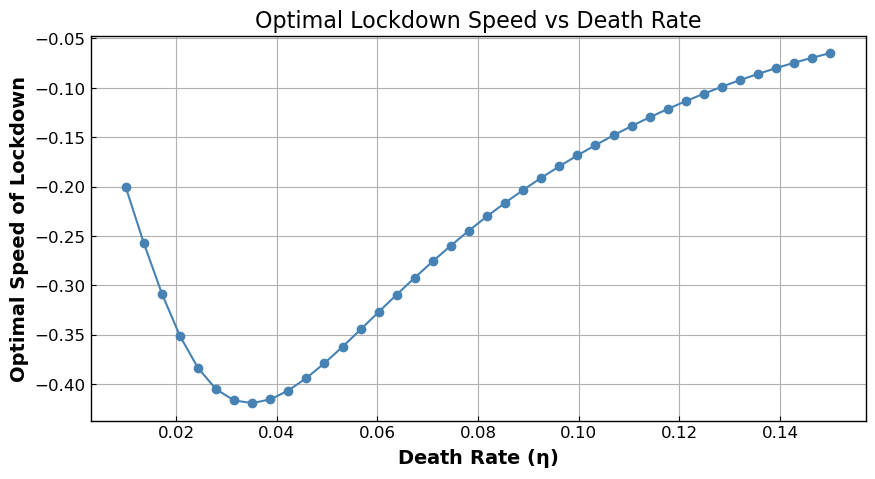

In [793]:
# sensitivity of optimal sharpness for different death rates

eta_values = np.linspace(0.01, 0.15, 40)
optimal_sharpness_pt = np.zeros(len(eta_values))
for i, eta in enumerate(eta_values):
    res = minimize_scalar(
        total_cost,
        bounds=(-2.0, -0.001),
        method="bounded",
        args=(alpha, t_span, X0, pt, b, c, eta, gamma, nu, N),
    )
    optimal_sharpness_pt[i] = res.x
plt.figure(figsize=(10, 5))
plt.plot(eta_values, optimal_sharpness_pt, marker="o", color="steelblue")
plt.xlabel("Death Rate ($\\eta$)")
plt.ylabel("Optimal Speed of Lockdown")
plt.title("Optimal Lockdown Speed vs Death Rate", fontsize=16)
plt.grid()
plt.show()